In [1]:
import itertools

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import torch
from torch.distributions import MultivariateNormal

import flows
import nn as flows_nn

In [2]:
%env CUDA_VISIBLE_DEVICES=0

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

env: CUDA_VISIBLE_DEVICES=0


device(type='cpu')

### Datasets:

In [3]:
# Lightweight datasets
import pickle
from sklearn import datasets

class DatasetMoons:
    """ two half-moons """
    def sample(self, n):
        moons = datasets.make_moons(n_samples=n, noise=0.05)[0].astype(np.float32)
        return torch.from_numpy(moons)

class DatasetMixture:
    """ 4 mixture of gaussians """
    def sample(self, n):
        assert n%4 == 0
        r = np.r_[np.random.randn(n // 4, 2)*0.5 + np.array([0, -2]),
                  np.random.randn(n // 4, 2)*0.5 + np.array([0, 0]),
                  np.random.randn(n // 4, 2)*0.5 + np.array([2, 2]),
                  np.random.randn(n // 4, 2)*0.5 + np.array([-2, 2])]
        return torch.from_numpy(r.astype(np.float32))

# d = DatasetMoons()
d = DatasetMoons()

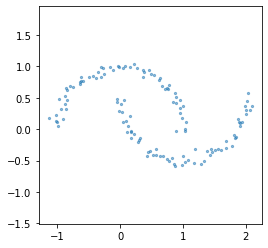

In [4]:
x = d.sample(128)
plt.figure(figsize=(4,4))
plt.scatter(x[:,0], x[:,1], s=5, alpha=0.5)
plt.axis('equal');


### Models:


In [5]:
# construct a model

dim = 2
prior = MultivariateNormal(torch.zeros(dim), torch.eye(dim))

# RealNVP - AffineHalfFlow(dim=dim)

# NICE - AffineHalfFlow(dim=dim, scale=False)

# MAF - MAF(dim=dim)

# IAF - IAF(dim=dim)

# norms - ActNorm(dim=dim)

# Glow - Invertible1x1Conv(dim=dim)

# Neural splines, coupling - NSF_CL(dim=dim)

# Neural splines, autoregressive - NSF_AR(dim=dim)

# flows = [choices[np.random.randint(len(choices))](dim=dim) for _ in range(10)]
# list_flows = [flows.NSF_AR(dim=dim, base_network=flows_nn.ARMLP),
#               flows.Invertible1x1Conv(dim=dim),
#               flows.NSF_AR(dim=dim, base_network=flows_nn.ARMLP)]
list_flows = [flows.MAF(dim=dim, base_network=flows_nn.ARMLP),
              flows.InvertiblePermutation(dim=dim),
              flows.MAF(dim=dim, base_network=flows_nn.ARMLP)]
# construct the model
model = flows.NormalizingFlowModel(prior, list_flows).to(device)


torch.Size([32, 2]) (32, 2)
torch.Size([32, 32]) (32, 32)
torch.Size([32, 32]) (32, 32)
torch.Size([4, 32]) (32, 32)
torch.Size([32, 2]) (32, 2)
torch.Size([32, 32]) (32, 32)
torch.Size([32, 32]) (32, 32)
torch.Size([4, 32]) (32, 32)


In [6]:
# optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
print("number of params: ", sum(p.numel() for p in model.parameters()))

number of params:  5084


### Train loop


In [7]:
model.train()
for k in range(5000):
    x = d.sample(128)
    
    zs, prior_logprob, log_det = model(x.to(device))
    logprob = prior_logprob + log_det
    loss = -torch.sum(logprob)

    model.zero_grad()
    loss.backward()
    optimizer.step()

    if k % 500 == 0:
        print(loss.item())


567.9574584960938
280.707763671875
207.24105834960938
158.91741943359375
144.01075744628906
156.17247009277344
123.06973266601562
126.08332824707031
107.84950256347656
115.87725830078125


### Results:

Text(0.5, 1.0, 'z -> x')

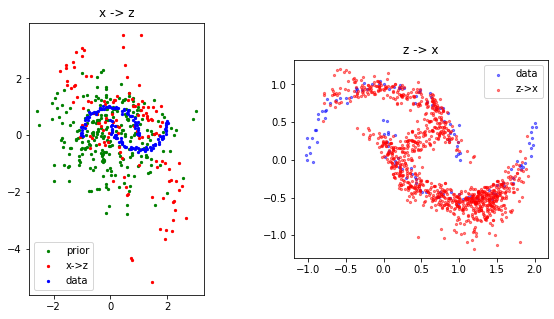

In [8]:
model.eval()

x = d.sample(128)
z, prior_logprob, log_det = model(x)

x = x.detach().numpy()
z = z.detach().numpy()
p = model.prior.sample([128, 2]).squeeze()
plt.figure(figsize=(10,5))
plt.subplot(121)
plt.scatter(p[:,0], p[:,1], c='g', s=5)
plt.scatter(z[:,0], z[:,1], c='r', s=5)
plt.scatter(x[:,0], x[:,1], c='b', s=5)
plt.legend(['prior', 'x->z', 'data'])
plt.axis('scaled')
plt.title('x -> z')

z = model.sample(128*8)
z = z.detach().numpy()
plt.subplot(122)
plt.scatter(x[:,0], x[:,1], c='b', s=5, alpha=0.5)
plt.scatter(z[:,0], z[:,1], c='r', s=5, alpha=0.5)
plt.legend(['data', 'z->x'])
plt.axis('scaled')
plt.title('z -> x')